# Parallelism in Computer Vision

## Setup

### Imports

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from pathlib import Path
import zipfile
import urllib.request
from typing import List

from concurrent.futures import ProcessPoolExecutor, as_completed

2025-09-02 08:22:34.765031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 08:22:35.702177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 08:22:39.370469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


### Google Colab

In [2]:
# Check if running of Google Colab
def is_running_on_colab():
    try:
        if 'google.colab' in str(get_ipython()):
            return True
        else:
            return False
    except NameError:
        return False

if is_running_on_colab():
    print("Running on Google Colab")

    # Check for available GPUs and, if found, configure TensorFlow to use memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Ensure at least one GPU is available
        if physical_devices:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
            print("GPU memory growth enabled.")
        else:
            print("No GPU devices found.")
    except:
        print(f"Error setting GPU memory growth: {e}")
        pass

    # Get GPU infos
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

    # Connect to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Setup the Google root
    root_path = "./drive/MyDrive/Project/Python_parallelism"

    # Install jiwer for the calculate_average_wer function
    ! pip install jiwer
else:
    print("Running on a local machine")
    # Setup the local root
    root_path = ".."

# Displays the number of avaible GPUs
print("\nNum GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Running on a local machine

Num GPUs Available:  0


2025-09-02 08:22:54.011091: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Global Variables and Data paths for Caltech101 dataset

In [3]:
SAMPLE_SIZE = 1250

DATA_ROOT = Path(root_path, "data")
ARCHIVE_URL = "https://www.kaggle.com/api/v1/datasets/download/imbikramsaha/caltech-101"
ARCHIVE_PATH = DATA_ROOT / "caltech101.zip"
EXTRACT_DIR = DATA_ROOT / "caltech-101"

print(f"Data folder set to {DATA_ROOT}")


Data folder set to ../data


### Tools

In [4]:
def time_it(func):
    """Decorator to measure execution time of functions."""
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start:.4f}s")
        return result
    return wrapper

### Download Caltech101 dataset

In [5]:
def ensure_caltech101():
    if EXTRACT_DIR.exists() and any(EXTRACT_DIR.iterdir()):
        print("Caltech101 dataset already exists.")
        return
    print("Downloading Caltech101 archive...")
    urllib.request.urlretrieve(ARCHIVE_URL, ARCHIVE_PATH)
    print("Extracting Caltech101 archive...")
    with zipfile.ZipFile(ARCHIVE_PATH, "r") as zip_ref:
        zip_ref.extractall(path=DATA_ROOT)
    print("Caltech101 dataset extracted to", EXTRACT_DIR)

ensure_caltech101()


Caltech101 dataset already exists.


### Sample Images

In [4]:
def sample_images(root: Path, limit=None) -> List[Path]:
    extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    paths = [path for path in root.rglob("*") if path.suffix.lower() in extensions]
    return paths[:limit] if limit else paths

paths = sample_images(EXTRACT_DIR, limit=None)
len(paths), paths[:5]


(9144,
 [PosixPath('../data/caltech-101/yin_yang/image_0042.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0002.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0053.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0009.jpg'),
  PosixPath('../data/caltech-101/yin_yang/image_0019.jpg')])

## Preprocess Pipeline

### Resize, grayscale, Sobel edges.

In [5]:
def load_resize(path, size=(224,224)):
    """
    Open an image, convert it to RGB to ensure we have 3 channels, and resize it.
    Returns a NumPy array of shape (height, width, 3).
    """
    with Image.open(path) as img:
        img = img.convert("RGB").resize(size, Image.BILINEAR)
        return np.array(img, dtype=np.uint8)

def to_gray(img_rgb):
    """
    Convert an RGB image to grayscale using perceptual weights.
    Returns a NumPy array of shape (height, width).
    """
    # Use ellipsis (...) to select all pixels
    r, g, b = img_rgb[..., 0], img_rgb[..., 1], img_rgb[..., 2]
    # Apply ITU-R 601 to calculate luminance
    # Cast float32 to avoid overflow later
    return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float32)

def sobel_edges(img_gray):
    """
    Apply the Sobel operator to a grayscale image of shape (height, width) to detect edges.
    Returns a NumPy array of the same shape as the input image.
    """
    # Create two 3x3 Sobel kernels
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[ 1, 2, 1],
                        [ 0, 0, 0],
                        [-1,-2,-1]], dtype=np.float32)

    grad = np.pad(img_gray, ((1, 1), (1, 1)), mode='edge')
    grad_x = (
        grad[:-2, :-2] * sobel_x[0, 0] + grad[:-2, 1:-1] * sobel_x[0, 1] + grad[:-2, 2:] * sobel_x[0, 2] +
        grad[1:-1, :-2] * sobel_x[1, 0] + grad[1:-1, 1:-1] * sobel_x[1, 1] + grad[1:-1, 2:] * sobel_x[1, 2] +
        grad[2:, :-2] * sobel_x[2, 0] + grad[2:, 1:-1] * sobel_x[2, 1] + grad[2:, 2:] * sobel_x[2, 2]
    )
    grad_y = (
        grad[:-2, :-2] * sobel_y[0, 0] + grad[:-2, 1:-1] * sobel_y[0, 1] + grad[:-2, 2:] * sobel_y[0, 2] +
        grad[1:-1, :-2] * sobel_y[1, 0] + grad[1:-1, 1:-1] * sobel_y[1, 1] + grad[1:-1, 2:] * sobel_y[1, 2] +
        grad[2:, :-2] * sobel_y[2, 0] + grad[2:, 1:-1] * sobel_y[2, 1] + grad[2:, 2:] * sobel_y[2, 2]
    )
    return np.sqrt(grad_x**2 + grad_y**2).astype(np.float32)

## Serial Preprocessing

### Full dictionary

In [6]:
def preprocess_one(path, size=(224, 224), bins=32):
    """
    Preprocess pipeline for one image.
    Returns a dictionary containing components for reuse.
    """
    img_resized = load_resize(path, size)
    img_gray = to_gray(img_resized)
    img_edges = sobel_edges(img_gray)

    hists = []
    for channel in range(3):
        hist_channel, _ = np.histogram(img_resized[..., channel], bins=bins, range=(0, 255))
        hists.append(hist_channel.astype(np.float32))

    color_hist = np.concatenate(hists, axis=0)

    return {
        "path": str(path),
        "resized": img_resized,
        "gray": img_gray,
        "edges": img_edges,
        "color_hist": color_hist,
        "size": size,
        "bins": bins
    }

def preprocess_all_serial(image_paths, size=(224, 224), bins=32, limit=None):
    """
    Preprocess pipeline for a list of images.
    Returns a list of dictionaries, each containing components for reuse.
    """
    if limit is not None:
        image_paths = image_paths[:limit]
    return [preprocess_one(path, size=size, bins=bins) for path in image_paths]


### Minimal dictionary

In [7]:
def preprocess_one_min(path, size=(224,224), bins=32):
    '''
    Preprocess pipeline for one image.
    Returning a minimal dictionary of features.
    '''
    img = load_resize(path, size)
    gray = to_gray(img)
    edges = sobel_edges(gray)
    # Simple feature: edge mean + color hist (density)
    hists = []
    for c in range(3):
        h, _ = np.histogram(img[..., c], bins=bins, range=(0,255), density=True)
        hists.append(h.astype(np.float32))
    color_hist = np.concatenate(hists)
    return {
        "path": str(path),
        "edge_mean": float(edges.mean()),
        "edge_max": float(edges.max()),
        "color_hist": color_hist
    }


### Performance test on different image size

In [14]:
import time, statistics as stats

def measure_components(paths, limit=60, size=(224,224)):
    t_load = []
    t_compute = []

    if not limit:
        limit = len(paths)

    for p in paths[:limit]:
        t0 = time.perf_counter()
        img = load_resize(p, size=size)
        t1 = time.perf_counter()
        gray = to_gray(img)
        edges = sobel_edges(gray)
        t2 = time.perf_counter()
        t_load.append(t1 - t0)
        t_compute.append(t2 - t1)
    return {
        "n": limit,
        "load_mean": stats.mean(t_load),
        "compute_mean": stats.mean(t_compute),
        "load_total": sum(t_load),
        "compute_total": sum(t_compute)
    }


#### 224x224

In [15]:
component_stats_224 = measure_components(paths, limit=SAMPLE_SIZE, size=(224,224))
component_stats_224

{'n': 5000,
 'load_mean': 0.0035048333763821574,
 'compute_mean': 0.001687629114407173,
 'load_total': 17.524166881910787,
 'compute_total': 8.438145572035864}

#### 112x112

In [17]:
component_stats_112 = measure_components(paths, limit=SAMPLE_SIZE, size=(112,112))
component_stats_112

{'n': 5000,
 'load_mean': 0.0023690059279513663,
 'compute_mean': 0.0007657839100458659,
 'load_total': 11.84502963975683,
 'compute_total': 3.8289195502293296}

#### 56x56

In [19]:
component_stats_56 = measure_components(paths, limit=SAMPLE_SIZE, size=(56,56))
component_stats_56

{'n': 5000,
 'load_mean': 0.0021029290436330485,
 'compute_mean': 0.0005401675909852201,
 'load_total': 10.514645218165242,
 'compute_total': 2.700837954926101}

## Parallel Preprocessing

### Full dictionary

In [8]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import os, math

def preprocess_parallel(paths, size=(224,224), bins=32, max_workers=None, limit=None):
    '''
    Preprocess pipeline using ProcessPoolExecutor for parallel processing.
    '''
    if limit: paths = paths[:limit]
    t0 = time.perf_counter()
    out = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(preprocess_one, p, size, bins) for p in paths]
        for f in as_completed(futures):
            out.append(f.result())
    elapsed = time.perf_counter() - t0
    return out, elapsed

par_samples, par_time = preprocess_parallel(paths, limit=SAMPLE_SIZE)
print(f"ProcessPool full objects: {len(par_samples)} images in {par_time:.2f}s")

ProcessPool full objects: 1250 images in 9.33s


### Minimal dictionary

In [9]:
def preprocess_parallel_min(paths, size=(224,224), bins=32, max_workers=None, limit=None):
    if limit: paths = paths[:limit]
    t0 = time.perf_counter()
    out = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(preprocess_one_min, p, size, bins) for p in paths]
        for f in as_completed(futures):
            out.append(f.result())
    elapsed = time.perf_counter() - t0
    return out, elapsed

par_min_samples, par_min_time = preprocess_parallel_min(paths, limit=SAMPLE_SIZE)
print(f"ProcessPool minimal dict: {len(par_min_samples)} images in {par_min_time:.2f}s")

ProcessPool minimal dict: 1250 images in 6.82s


### Preprocessing using threads

In [10]:
from concurrent.futures import ThreadPoolExecutor

def preprocess_threads(paths, size=(224,224), bins=32, limit=None):
    '''
    Preprocess pipeline using ThreadPoolExecutor for parallel processing.
    '''
    if limit: paths = paths[:limit]
    t0 = time.perf_counter()
    with ThreadPoolExecutor() as ex:
        results = list(ex.map(lambda p: preprocess_one(p, size, bins), paths))
    return results, time.perf_counter() - t0

thr_samples, thr_time = preprocess_threads(paths, limit=SAMPLE_SIZE)
print(f"ThreadPool: {len(thr_samples)} images in {thr_time:.2f}s")

ThreadPool: 1250 images in 15.67s


## Evaluating Process Speedup

In [11]:
t0 = time.perf_counter()
serial_subset = preprocess_all_serial(paths, limit=SAMPLE_SIZE)
serial_time = time.perf_counter() - t0
print(f"Serial ({SAMPLE_SIZE} images): {serial_time:.2f}s")

print(f"Speedups vs serial:")
print(f"  Processes (full objects): {serial_time / par_time:.2f}x")
print(f"  Processes (minimal dict): {serial_time / par_min_time:.2f}x")
print(f"  Threads: {serial_time / thr_time:.2f}x")

Serial (1250 images): 10.96s
Speedups vs serial:
  Processes (full objects): 1.17x
  Processes (minimal dict): 1.61x
  Threads: 0.70x


## Batch Preprocessing

In [12]:
def worker(batch, size, bins):
    out = []
    for p in batch:
        out.append(preprocess_one_min(p, size=size, bins=bins))
    return out

def preprocess_parallel_batches(paths, size=(224,224), bins=32, batch_size=16, max_workers=None, limit=None):
    if limit: paths = paths[:limit]
    batches = [paths[i:i+batch_size] for i in range(0, len(paths), batch_size)]

    t_start = time.perf_counter()
    first_future_submit = None
    first_result_time = None

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = []
        for b in batches:
            if first_future_submit is None:
                first_future_submit = time.perf_counter()
            futures.append(ex.submit(worker, b, size, bins))
        for i, f in enumerate(as_completed(futures)):
            r = f.result()
            if first_result_time is None:
                first_result_time = time.perf_counter()
            results.extend(r)
    t_end = time.perf_counter()

    return {
        "n_images": len(results),
        "total_time": t_end - t_start,
        "submit_overhead": (first_future_submit - t_start) if first_future_submit else None,
        "time_until_first_result": (first_result_time - t_start) if first_result_time else None,
        "batch size": batch_size,
        "max_workers": max_workers
    }

stats_batch = preprocess_parallel_batches(paths, limit=SAMPLE_SIZE, batch_size=8)
stats_batch

{'n_images': 1250,
 'total_time': 10.015896146999694,
 'submit_overhead': 0.08358591099977275,
 'time_until_first_result': 2.1671027269999286,
 'batch size': 8,
 'max_workers': None}

### Explore the effect of batchsize on the preprocessing with ProcessPoolExecutor

In [24]:
batch_sizes = [1, 4, 8, 16, 24, 32, 48, 64]
sweep = []
for b in batch_sizes:
    s = preprocess_parallel_batches(paths, limit=SAMPLE_SIZE, batch_size=b)
    sweep.append(s)
    print(f"batch={b:2d} total={s['total_time']:.3f}s first_result={s['time_until_first_result']:.3f}s")

# Find best
best = min(sweep, key=lambda d: d['total_time'])
print("\nBest batch config:", best)

batch= 1 total=9.545s first_result=0.740s


KeyboardInterrupt: 

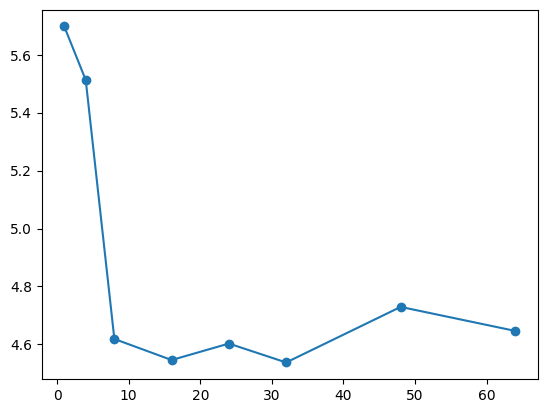

In [ ]:
total_times = [d['total_time'] for d in sweep]

plt.plot(batch_sizes, total_times, marker='o')